# Bayesian Monthly Sensitivity Model

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

In [2]:
states=['Indiana','Illinois']

In [3]:
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    temp_states.append(maize_temp)
temp_states=pd.concat(temp_states,keys=states)

In [4]:
# Compile model
sm=pystan.StanModel(file='BMSM-simp.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7839d65b913f1005fc3976af2843100 NOW.


In [5]:
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [6]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':2,
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,1:]).reshape(len(states),np.int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float)
}

In [7]:
fit=sm.sampling(data=data,chains=4,iter=1000,verbose=True)

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
fit

Inference for Stan model: anon_model_e7839d65b913f1005fc3976af2843100.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_temp[0,0]           0.05  2.0e-3   0.07  -0.09 3.3e-3   0.05    0.1   0.19   1435    1.0
s_temp[1,0]           0.05  1.5e-3   0.07  -0.08 9.2e-3   0.06    0.1   0.19   2000    1.0
s_temp[0,1]          -0.12  1.8e-3   0.08  -0.27  -0.18  -0.12  -0.07   0.04   2000    1.0
s_temp[1,1]          -0.06  1.6e-3   0.07   -0.2  -0.11  -0.06  -0.02   0.07   2000    1.0
s_temp[0,2]           -0.1  2.2e-3   0.09  -0.28  -0.16   -0.1  -0.03   0.08   1703    1.0
s_temp[1,2]          -0.15  2.1e-3   0.09  -0.32  -0.22  -0.15  -0.09   0.03   2000    1.0
s_temp[0,3]           0.13  3.0e-3   0.13  -0.13   0.03   0.12   0.22   0.39   2000    1.0
s_temp[1,3]           0.06  2.8e-3   0.13  -0.19  -0.03   0.05   0.14   0.31   2000  

In [9]:
# carry out some diagnostic checks on fit
from xidplus.stan_fit import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [10]:
samples=fit.extract()

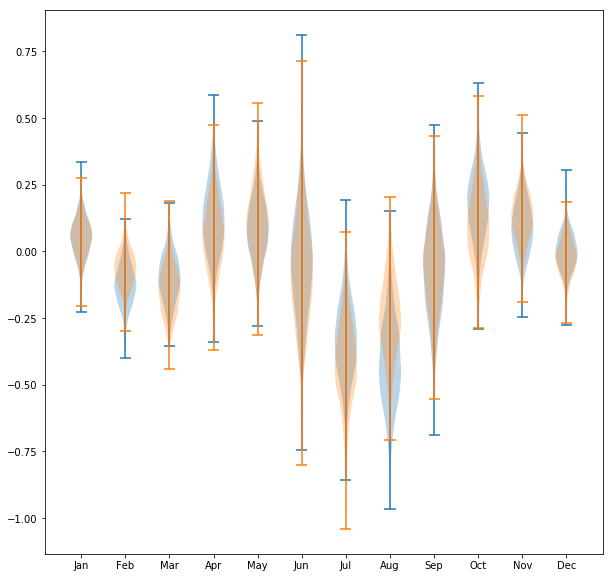

In [11]:
plt.figure(figsize=(10,10))
plt.violinplot(samples['s_temp'][:,0,:]);
plt.violinplot(samples['s_temp'][:,1,:]);
plt.xticks(range(1,13),maize_temp.columns[1:]);


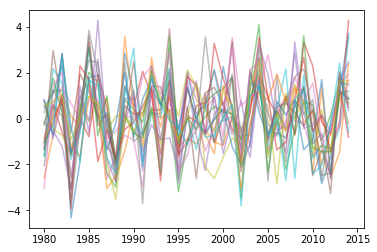

In [146]:
for s in range(0,2000,100):
    plt.plot(range(1980,2015),samples['d_yields_pred'][s,0,:].T,alpha=0.5)

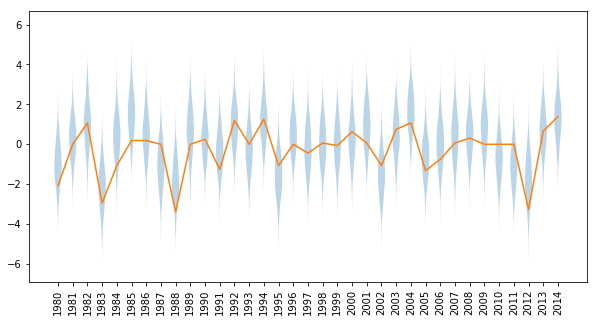

In [165]:
plt.figure(figsize=(10,5))
plt.violinplot(samples['d_yields_pred'][:,0,:],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),fit.data['d_yields'][0,:])


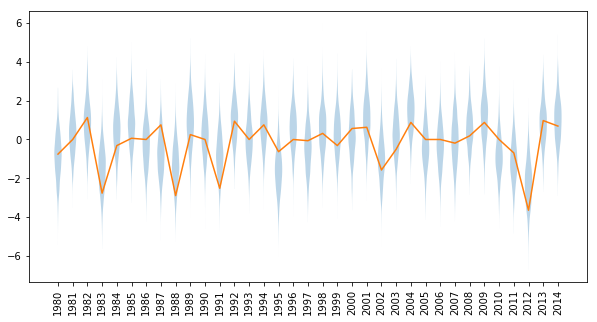

In [166]:
plt.figure(figsize=(10,5))
plt.violinplot(samples['d_yields_pred'][:,1,:],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),fit.data['d_yields'][1,:])


In [163]:
fit.data['d_yields'].shape

(2, 35)